In [1]:
import mediapipe as mp
import cv2
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

objc[15381]: Class CaptureDelegate is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x10b908860) and /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x287c9e480). One of the two will be used. Which one is undefined.
objc[15381]: Class CVWindow is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x104eeca68) and /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/cv2/cv2.abi3.so (0x287c9e4d0). One of the two will be used. Which one is undefined.
objc[15381]: Class CVView is implemented in both /Users/fuixlabsdev1/Programming/PP/graduation-thesis/env/lib/python3.8/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x104eeca90) and /Users/fuixlabsdev1/Programming/PP/graduation-th

In [2]:
# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)

### 1. Make some pose detections

In [ ]:
cap = cv2.VideoCapture("../data/plank/plank_2.mov")

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()
        image = cv2.flip(image, 1)

        if not ret:
            break

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        cv2.imshow("CV2", image)

        # Press Q to close cv2 window
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)

### 2. Build dataset from collected videos and picture from Kaggle to .csv file for dataset

In [4]:
import csv
import os

#### 2.1 Determine important keypoints and set up important functions

There are 3 stages that I try to classify for Plank Exercise Correction:

- Correct: "C"
- Back is too low: "L"
- Back is too high: "H"

In [5]:
# Determine important landmarks for plank
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_ELBOW",
    "RIGHT_ELBOW",
    "LEFT_WRIST",
    "RIGHT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE",
    "LEFT_HEEL",
    "RIGHT_HEEL",
    "LEFT_FOOT_INDEX",
    "RIGHT_FOOT_INDEX",
]

# Generate all columns of the data frame

HEADERS = ["label"] # Label column

for lm in IMPORTANT_LMS:
    HEADERS += [f"{lm.lower()}_x", f"{lm.lower()}_y", f"{lm.lower()}_z", f"{lm.lower()}_v"]

HEADERS[1:]

['nose_x',
 'nose_y',
 'nose_z',
 'nose_v',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_z',
 'left_shoulder_v',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_z',
 'right_shoulder_v',
 'left_elbow_x',
 'left_elbow_y',
 'left_elbow_z',
 'left_elbow_v',
 'right_elbow_x',
 'right_elbow_y',
 'right_elbow_z',
 'right_elbow_v',
 'left_wrist_x',
 'left_wrist_y',
 'left_wrist_z',
 'left_wrist_v',
 'right_wrist_x',
 'right_wrist_y',
 'right_wrist_z',
 'right_wrist_v',
 'left_hip_x',
 'left_hip_y',
 'left_hip_z',
 'left_hip_v',
 'right_hip_x',
 'right_hip_y',
 'right_hip_z',
 'right_hip_v',
 'left_knee_x',
 'left_knee_y',
 'left_knee_z',
 'left_knee_v',
 'right_knee_x',
 'right_knee_y',
 'right_knee_z',
 'right_knee_v',
 'left_ankle_x',
 'left_ankle_y',
 'left_ankle_z',
 'left_ankle_v',
 'right_ankle_x',
 'right_ankle_y',
 'right_ankle_z',
 'right_ankle_v',
 'left_heel_x',
 'left_heel_y',
 'left_heel_z',
 'left_heel_v',
 'right_heel_x',
 'right_heel_y',
 'right_heel_z',
 

In [7]:
def init_csv(dataset_path: str):
    '''
    Create a blank csv file with just columns
    '''

    # Write all the columns to a file
    with open(dataset_path, mode="w", newline="") as f:
        csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
        csv_writer.writerow(HEADERS)


def export_landmark_to_csv(dataset_path: str, results, action: str) -> None:
    '''
    Export Labeled Data from detected landmark to csv
    '''
    landmarks = results.pose_landmarks.landmark
    keypoints = []

    try:
        # Extract coordinate of important landmarks
        for lm in IMPORTANT_LMS:
            keypoint = landmarks[mp_pose.PoseLandmark[lm].value]
            keypoints.append([keypoint.x, keypoint.y, keypoint.z, keypoint.visibility])
        
        keypoints = list(np.array(keypoints).flatten())

        # Insert action as the label (first column)
        keypoints.insert(0, action)

        # Append new row to .csv file
        with open(dataset_path, mode="a", newline="") as f:
            csv_writer = csv.writer(f, delimiter=",", quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
        

    except Exception as e:
        print(e)
        pass


def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def remove_duplicate_rows(dataset_path: str):
    '''
    Remove duplicated data from the dataset then save it to another files
    '''
    
    df = pd.read_csv(dataset_path)
    df.drop_duplicates(keep="first", inplace=True)
    df.to_csv(f"cleaned_dataset.csv", sep=',', encoding='utf-8', index=False)
    

def concat_csv_files_with_same_headers(file_paths: list, saved_path: str):
    '''
    Concat different csv files
    '''
    all_df = []
    for path in file_paths:
        df = pd.read_csv(path, index_col=None, header=0)
        all_df.append(df)
    
    results = pd.concat(all_df, axis=0, ignore_index=True)
    results.to_csv(saved_path, sep=',', encoding='utf-8', index=False)

#### 2.2 Extract from video


In [51]:
DATASET_PATH = "bad_data.csv"

cap = cv2.VideoCapture("../data/plank/bad/plank_bad_1.mov")
save_counts = 0

# init_csv(DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, image = cap.read()

        if not ret:
            break

        # Reduce size of a frame
        image = rescale_frame(image, 60)
        # image = cv2.flip(image, 1)

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"Saved: {save_counts}", (50, 50), cv2.FONT_HERSHEY_COMPLEX, 2, (0, 0, 0), 1, cv2.LINE_AA)

        cv2.imshow("CV2", image)

        # Pressed key for action
        k = cv2.waitKey(1) & 0xFF

        # Press C to save as correct form
        if k == ord('c'): 
            export_landmark_to_csv(DATASET_PATH, results, "C")
            save_counts += 1
        # Press L to save as low back
        elif k == ord("l"):
            export_landmark_to_csv(DATASET_PATH, results, "L")
            save_counts += 1

        # Press q to stop
        elif k == ord("q"):
            break
        else: continue

    cap.release()
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)
        

In [52]:
df = describe_dataset(DATASET_PATH)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

In [53]:
# csv_files = [os.path.join("./", f) for f in os.listdir("./") if "csv" in f]

# concat_csv_files_with_same_headers(csv_files, "dataset.csv")

df = describe_dataset("./dataset.csv")

#### 2.3. Extract from Kaggle dataset ([download here](https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset))

In [ ]:
FOLDER_PATH = "../data/kaggle/TRAIN/plank"
picture_files = [os.path.join(FOLDER_PATH, f) for f in os.listdir(FOLDER_PATH) if os.path.isfile(os.path.join(FOLDER_PATH, f))]
print(f"Total pictures: {len(picture_files)}")

DATASET_PATH = "./data.csv"
saved_counts = 0

# init_csv(DATASET_PATH)

with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.5) as pose:
    index = 0
    
    while True:
        if index == len(picture_files):
            break
        
        file_path = picture_files[index]

        image = cv2.imread(file_path)

        # Flip image horizontally for more data
        # image = cv2.flip(image, 1)

        # get dimensions of image
        dimensions = image.shape
        
        # height, width, number of channels in image
        height = image.shape[0]
        width = image.shape[1]
        channels = image.shape[2]

        # Reduce size of a frame
        if width > 1000:
            image = rescale_frame(image, 60)

        # Recolor image from BGR to RGB for mediapipe
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        results = pose.process(image)

        # Recolor image from BGR to RGB for mediapipe
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw landmarks and connections
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, mp_drawing.DrawingSpec(color=(244, 117, 66), thickness=2, circle_radius=4), mp_drawing.DrawingSpec(color=(245, 66, 230), thickness=2, circle_radius=2))

        # Display the saved count
        cv2.putText(image, f"Saved: {saved_counts}", (20, 20), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)
        
        cv2.imshow("CV2", image)

        k = cv2.waitKey(1) & 0xFF

        if k == ord('d'): 
            index += 1

        elif k == ord("s"):
            export_landmark_to_csv(DATASET_PATH, results, "C")
            saved_counts += 1

        elif k == ord("f"):
            index += 1
            os.remove(file_path)

        elif k == ord("q"):
            break

        else:
            continue

        # # Press Q to close cv2 window
        # if cv2.waitKey(1) & 0xFF == ord('d'):
        #     index += 1

        # # Press Q to close cv2 window
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break

    # Close cv2 window
    cv2.destroyAllWindows()

    # (Optional)Fix bugs cannot close windows in MacOS (https://stackoverflow.com/questions/6116564/destroywindow-does-not-close-window-on-mac-using-python-and-opencv)
    for i in range (1, 5):
        cv2.waitKey(1)

        
        

In [ ]:
df = describe_dataset(DATASET_PATH)

#### 2.4. Processed Collected Data

In [ ]:
df = describe_dataset("./dataset.csv")

### 3. Train Model

#### 3.1. Describe data and split dataset

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
df = describe_dataset("./dataset.csv")

df.head(5)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'left_knee_v', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'right_knee_v', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'left_ankle_v', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z', 'right_ankle_v', 'left_heel_x', 'left_heel_y', 'left_heel_z', 'left_heel_v', 'right_heel_x', 'right_heel_y', 'right_heel_z', 'right_heel_v', 'left_foot_index_x', 'lef

,label,nose_x,nose_y,nose_z,nose_v,left_shoulder_x,left_shoulder_y,left_shoulder_z,left_shoulder_v,right_shoulder_x,...,right_heel_z,right_heel_v,left_foot_index_x,left_foot_index_y,left_foot_index_z,left_foot_index_v,right_foot_index_x,right_foot_index_y,right_foot_index_z,right_foot_index_v
0,L,0.851814,0.544296,-0.002149,0.999794,0.766442,0.442197,0.189666,0.997431,0.796362,...,-0.070822,0.932627,0.218225,0.718116,0.086244,0.639262,0.205335,0.728404,-0.157671,0.904007
1,L,0.852145,0.539951,-0.019670,0.999814,0.771065,0.448218,0.187370,0.997946,0.802738,...,-0.072686,0.932994,0.221010,0.709638,0.090496,0.637814,0.209463,0.721182,-0.153224,0.904961
2,L,0.852250,0.532665,-0.035205,0.999813,0.771667,0.447745,0.180610,0.998040,0.803314,...,-0.075445,0.933878,0.220634,0.707547,0.092103,0.640784,0.205483,0.721195,-0.152671,0.907735
3,L,0.852555,0.530069,-0.039986,0.999818,0.772392,0.445965,0.180539,0.998129,0.803327,...,-0.076146,0.935048,0.221000,0.707417,0.095977,0.636827,0.204576,0.721756,-0.151411,0.909001
4,L,0.853659,0.530436,-0.031443,0.999830,0.772422,0.443972,0.181999,0.998253,0.802383,...,-0.067255,0.936471,0.221743,0.707621,0.104690,0.629199,0.205166,0.725714,-0.144378,0.908903


In [141]:
# Extract features and class

X = df.drop("label", axis=1) # features
y = df["label"]

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [143]:
y_test.head(10)

2166    C
4903    C
310     L
489     L
143     L
1898    C
361     L
1337    L
3847    C
4765    C
Name: label, dtype: object

#### 4.2. Train model using Scikit-Learn

In [144]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score

In [145]:
algorithms =[("LR", LogisticRegression()),
         ("SVC", SVC()),
         ('KNN',KNeighborsClassifier()),
         ("DTC", DecisionTreeClassifier()),
         ("SGDC", SGDClassifier()),
         ("Ridge", RidgeClassifier()),
         ('RF', RandomForestClassifier()),]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model

    # Evaluate model
    model_results = model.predict(X_test)

    p_score = precision_score(y_test, model_results, average="macro")
    a_score = accuracy_score(y_test, model_results)
    f1_score_result = f1_score(y_test, model_results, average=None, labels=["C", "L"])
    final_results.append(( name, p_score, a_score, f1_score_result ))


final_results.sort(key=lambda k: k[3][0] + k[3][1], reverse=True)

In [146]:
pd.DataFrame(final_results, columns=["Model", "Precision Score", "Accuracy score" , "F1 score"])

,Model,Precision Score,Accuracy score,F1 score
0,KNN,1.000000,1.000000,"[1.0, 1.0]"
1,DTC,1.000000,1.000000,"[1.0, 1.0]"
2,RF,0.999093,0.998660,"[0.9990917347865577, 0.9974424552429668]"
3,SGDC,0.997813,0.997989,"[0.9986369831894593, 0.996168582375479]"
4,Ridge,0.997813,0.997989,"[0.9986369831894593, 0.996168582375479]"
5,LR,0.988292,0.993298,"[0.9954379562043797, 0.9873737373737373]"
6,SVC,0.976886,0.987265,"[0.9912883998165979, 0.9763387297633873]"


#### 4.3. Dumped model using pickle

According to the evaluations, there are multiple good models at the moment, therefore, I will pick the Random Forrest model to use.

In [147]:
# Dump the best model to a pickle file
import pickle

with open("./plank_model.pkl", "wb") as f:
    pickle.dump(models["KNN"], f)

### 5. Train model using Deep Learning

In [148]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
X = df.drop("label", axis=1) # features
y = df["label"]

y

0       L
1       L
2       L
3       L
4       L
       ..
4967    C
4968    C
4969    C
4970    C
4971    C
Name: label, Length: 4972, dtype: object

In [150]:
y = LabelBinarizer().fit_transform(y)

y = y.astype(int)

onehot_encoder = OneHotEncoder(sparse=False)
y = y.reshape(len(y), 1)
y = onehot_encoder.fit_transform(y)

y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

X_train.shape

(3480, 68)

In [152]:
model = Sequential()
model.add(Dense(68, input_dim=68, activation='relu'))
model.add(Dense(34, activation='relu'))
model.add(Dense(17, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test))

Epoch 1/100
  8/348 [..............................] - ETA: 2s - loss: 0.5932 - accuracy: 0.7750  

2022-09-21 14:42:17.044097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


343/348 [============================>.] - ETA: 0s - loss: 0.3654 - accuracy: 0.8359

2022-09-21 14:42:19.909633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


348/348 [==============================] - 4s 11ms/step - loss: 0.3618 - accuracy: 0.8376 - val_loss: 0.1013 - val_accuracy: 0.9826
Epoch 2/100
348/348 [==============================] - 4s 10ms/step - loss: 0.0874 - accuracy: 0.9672 - val_loss: 0.1318 - val_accuracy: 0.9129
Epoch 3/100
348/348 [==============================] - 3s 10ms/step - loss: 0.0566 - accuracy: 0.9816 - val_loss: 0.0333 - val_accuracy: 0.9866
Epoch 4/100
348/348 [==============================] - 3s 10ms/step - loss: 0.0488 - accuracy: 0.9842 - val_loss: 0.0519 - val_accuracy: 0.9799
Epoch 5/100
348/348 [==============================] - 3s 10ms/step - loss: 0.0381 - accuracy: 0.9862 - val_loss: 0.0229 - val_accuracy: 0.9913
Epoch 6/100
348/348 [==============================] - 4s 10ms/step - loss: 0.0310 - accuracy: 0.9885 - val_loss: 0.0477 - val_accuracy: 0.9819
Epoch 7/100
348/348 [==============================] - 3s 10ms/step - loss: 0.0331 - accuracy: 0.9882 - val_loss: 0.0573 - val_accuracy: 0.9826
Epoc

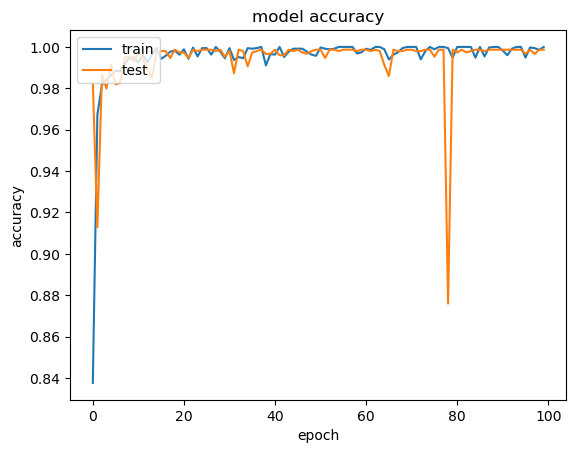

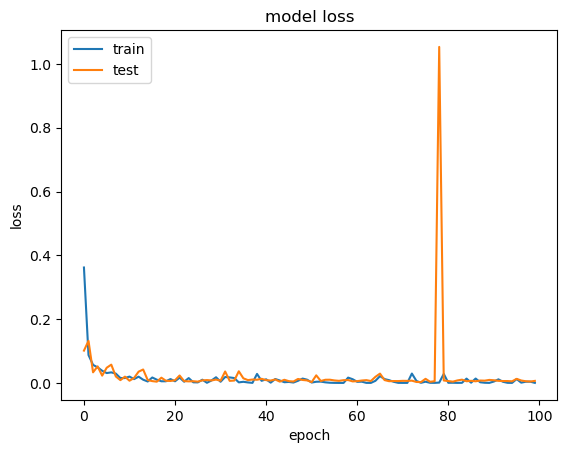

In [153]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [154]:
def print_confusion_matrix(confusion_matrix, class_names, figsize=(7, 5), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# define confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print_confusion_matrix(cm, ['correct', 'low back', ])

ValueError: Found input variables with inconsistent numbers of samples: [1492, 289]

In [155]:
# Dump the best model to a pickle file
with open("./plank_model_deep_learning.pkl", "wb") as f:
    pickle.dump(model, f)

INFO:tensorflow:Assets written to: ram://5c85d2c3-1143-487c-a057-186af57cdd56/assets
